In [1]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_features = torch.tensor([], dtype=torch.float)
train_labels = torch.tensor([], dtype=torch.int)

for i in tqdm(range(1, 61), desc='Loading Train Data', total=60):
    loaded_tensors = torch.load(f'/kaggle/input/imagenet-1k-data/trainset_{i}.pth', weights_only=True)
    train_features = torch.cat((train_features, loaded_tensors['trainset_features']), axis=0)
    train_labels = torch.cat((train_labels, loaded_tensors['trainset_labels']), axis=0)
    
train_indices = torch.randperm(train_features.shape[0])[:120000]
train_features = train_features[train_indices]
train_labels = train_labels[train_indices]

test_features = torch.tensor([], dtype=torch.float)
test_labels = torch.tensor([], dtype=torch.int)

for i in tqdm(range(1, 4), desc='Loading Test Data', total=3):
    loaded_tensors = torch.load(f'/kaggle/input/imagenet-1k-data/testset_{i}.pth', weights_only=True)
    test_features = torch.cat((test_features, loaded_tensors['testset_features']), axis=0)
    test_labels = torch.cat((test_labels, loaded_tensors['testset_labels']), axis=0)


test_indices = torch.randperm(test_features.shape[0])[:20000]
test_features = test_features[test_indices]
test_labels = test_labels[test_indices]

    
num_labels = 1000

print (train_features.shape)
print (train_labels.shape)
print (test_features.shape)
print (test_labels.shape)

Loading Test Data: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

torch.Size([120000, 2048])
torch.Size([120000])
torch.Size([20000, 2048])
torch.Size([20000])


In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_top_k_matches(train_features, test_features, train_indices, k=50):
    if len(train_indices) == 0:
        return np.array([[] for _ in test_features])

    # Get the features of images belonging to the same cluster
    cluster_features = train_features[train_indices]

    # Compute cosine similarity between the test image and cluster images
    similarities = cosine_similarity(test_features, cluster_features)
    
    # Get the top k most similar images
    top_k_indices = np.argsort(similarities, axis=1)[:, ::-1][:, :k]
    return train_indices[top_k_indices]

In [3]:
def precision_at_k(true_label, top_k_labels, k):
    top_k = top_k_labels[:k]
    correct = torch.sum(top_k == true_label).item()
    return correct / k

def mean_average_precision(true_label, top_k_labels):
    # Calculate precision at each rank and then compute average precision
    precisions = []
    correct = 0
    for i, label in enumerate(top_k_labels):
        if label == true_label:
            correct += 1
            precisions.append(correct / (i + 1))
    return np.mean(precisions) if precisions else 0


In [4]:
from collections import defaultdict

def generate_random_hyperplanes(num_features, num_planes):
    return torch.randn(num_features, num_planes)

def projection_hash(features, hyperplanes):
    projections = torch.mm(features, hyperplanes)
    hash_codes = (projections > 0).int()
    return hash_codes

def get_hash_codes(train_features, test_features, num_planes):
    assert train_features.shape[1] == test_features.shape[1], "Feature dimensions of train and test sets must match."
    hyperplanes = generate_random_hyperplanes(train_features.shape[1], num_planes)
    
    train_hash_codes = projection_hash(train_features, hyperplanes)

    powers_of_two = torch.pow(2, torch.arange(num_planes - 1, -1, -1)).int()
    
    train_hash_codes_dict = defaultdict(list)
    for i, train_hash_code in enumerate(train_hash_codes):
        key = torch.dot(train_hash_code, powers_of_two).item()
        train_hash_codes_dict[key].append(i)

    for code in train_hash_codes_dict.keys():
        train_hash_codes_dict[code] = np.array(train_hash_codes_dict[code])
    
    test_hash_codes = projection_hash(test_features, hyperplanes)
    test_hash_codes = np.array([torch.dot(test_hash_code, powers_of_two).item() for test_hash_code in test_hash_codes])
    
    return train_hash_codes_dict, test_hash_codes

In [5]:
def get_top_matches(train_features, test_features, num_planes):
    train_hash_codes_dict, test_hash_codes = get_hash_codes(train_features, test_features, num_planes)
    # For each test image, find the top 50 matches
    top_k_matches = [np.array([]) for _ in range(len(test_features))]
    for hash in range(2 ** num_planes):
        mask = (test_hash_codes == hash)
        mask_indices = np.nonzero(mask)[0]
        if (len(mask_indices) == 0):
            continue
        matches = get_top_k_matches(train_features, test_features[mask], train_hash_codes_dict[hash])
        for i, idx in enumerate(mask_indices):
            top_k_matches[idx] = matches[i]

    return top_k_matches

In [6]:
def evaluate(train_labels, test_labels, top_k_matches):
    # Evaluate for all test images
    precision_10 = []
    precision_50 = []
    mean_ap = []
    for i, matches in enumerate(top_k_matches):
        true_label = test_labels[i]
        matched_labels = train_labels[matches]

        precision_10.append(precision_at_k(true_label, matched_labels, 10))
        precision_50.append(precision_at_k(true_label, matched_labels, 50))
        mean_ap.append(mean_average_precision(true_label, matched_labels))

    return np.mean(precision_10), np.mean(precision_50), np.mean(mean_ap)

In [7]:
def run(train_features, train_labels, test_features, test_labels, num_planes):
    top_k_matches = get_top_matches(train_features, test_features, num_planes)
    return evaluate(train_labels, test_labels, top_k_matches)

Processing Num Clusters:: 100%|██████████| 6/6 [04:33<00:00, 45.50s/it]


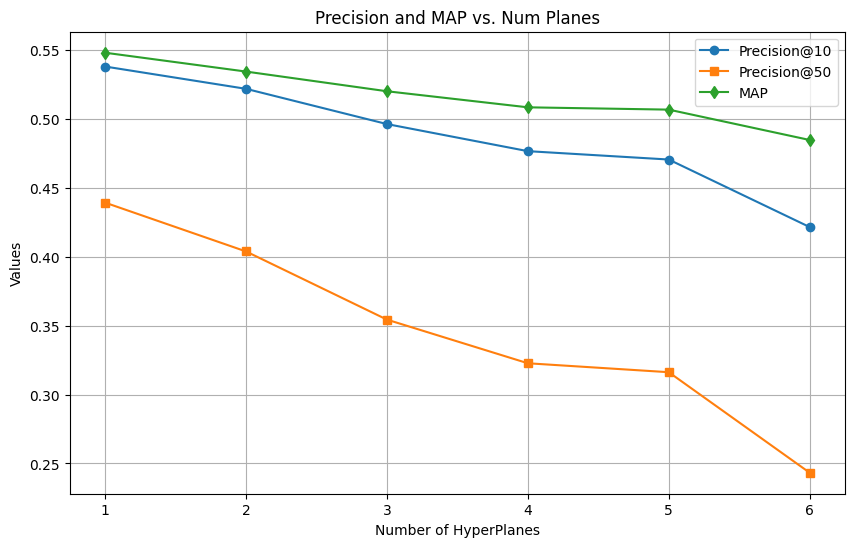

In [8]:
num_planes_list = list(range(1, 7))
prec_10_list = []
prec_50_list = []
map_list = []

for num_planes in tqdm(num_planes_list, desc='Processing Num Clusters:', total=len(num_planes_list)):
    prec_10, prec_50, map_value = run(train_features, train_labels, test_features, test_labels, num_planes)

    prec_10_list.append(prec_10)
    prec_50_list.append(prec_50)
    map_list.append(map_value)


import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_planes_list, prec_10_list, marker='o', label='Precision@10')
plt.plot(num_planes_list, prec_50_list, marker='s', label='Precision@50')
plt.plot(num_planes_list, map_list, marker='d', label='MAP')

# Adding titles and labels
plt.title('Precision and MAP vs. Num Planes')
plt.xlabel('Number of HyperPlanes')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.savefig('variation_with_num_hyperplanes.png', dpi=300)
# Show the plot
plt.show()